# Part 1 Get the dataset

###Get the reviews dataset

In [ ]:
import os
import pandas as pd

folder_path = '2_reviews_per_movie_raw'

files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

df = pd.DataFrame()

for f in files:
    file_path = os.path.join(folder_path, f)
    csv_data = pd.read_csv(file_path)
    csv_data["Movie"] = f[:-8]  
    df = pd.concat([df, csv_data], axis=0)

output_file_path = os.path.join(folder_path, 'merged.csv')
df.to_csv(output_file_path, index=False)

In [ ]:
import csv

with open('keywords.txt', encoding='ISO-8859-1') as txtfile:
    with open('output.csv', 'w', newline='') as csvfile:
        txtreader = csv.reader(txtfile, delimiter='\t')
        csvwriter = csv.writer(csvfile, delimiter=',')
        for row in txtreader:
            col1 = row[0]
            col2 = '\t'.join(row[2:]).replace('\t', ' ')
            csvwriter.writerow([col1, col2])

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'Colab Notebooks', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)
reviews_subset_data_path = os.path.join(GOOGLE_DRIVE_PAwTH, 'merged.csv')
output_subset_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'output.csv')

Mounted at /content/drive


In [3]:
reviews = pd.read_csv(reviews_subset_data_path)

In [4]:
reviews.head()

,username,rating,helpful,total,date,title,review,Movie
0,diac228,9,78,83,11 July 2008,With enough energy to generate an entire city...,"The 90s was home to a slew of great raw, uncut...",The Rock
1,F0RCE,10,287,342,21 March 2001,Definitely underrated!\n,"""The Rock"" combined action, adventure, comedy,...",The Rock
2,mstomaso,8,73,89,27 March 2005,Adrenalized..... yikes\n,The Rock is one of my all-time favorite suspen...,The Rock
3,charlie-303,10,140,184,31 January 2005,An absolute classic\n,What can I say other than Connery at his best ...,The Rock
4,clanger1977,9,114,150,1 May 2004,Review\n,The Rock was an awesome film to see in the cin...,The Rock


In [5]:
reviews['Movie'] = reviews['Movie'].str.strip()

In [6]:
reviews.dropna(inplace = True)

In [7]:
reviews = reviews[reviews != 'Null'].dropna()

In [8]:
reviews["rating"] = reviews["rating"].astype(int)

In [9]:
np.mean(reviews["rating"])

7.178830523897839

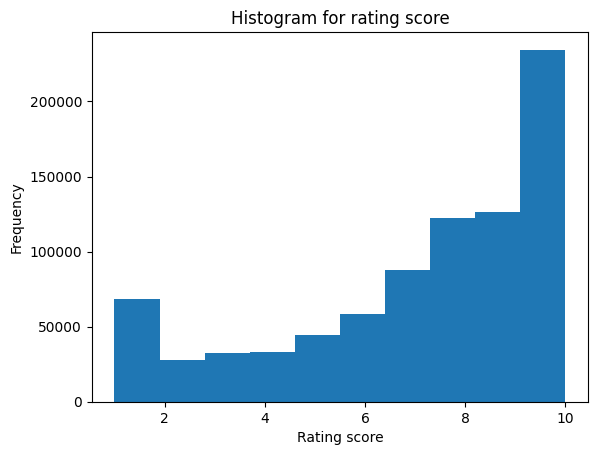

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram
plt.hist(reviews["rating"], bins=10)

# Set the title and labels for the axes
plt.title('Histogram for rating score')
plt.xlabel('Rating score')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

###Get the keywords dataset

In [11]:
keywords = pd.read_csv(output_subset_data_path)

In [12]:
keywords.columns

Index(['movie', '   key'], dtype='object')

In [13]:
keywords = keywords.rename(columns={'movie': 'Movie', '   key': 'key'})

In [14]:
keywords['Movie'] = keywords['Movie'].str.split('(', n=1).str[0]
keywords['Movie'] = keywords['Movie'].str.strip().str.strip('"')
keywords['key'] = keywords['key'].str.strip().str.strip('"')

In [15]:
keywords['key'] = keywords['key'].astype(str)

In [16]:
keywords_result = keywords.groupby('Movie')['key'].apply(lambda x: ','.join(x)).reset_index()

Join the two dataset

In [17]:
result_df = pd.merge(keywords_result, reviews, on='Movie', how='inner')

In [18]:
len(result_df["Movie"].unique())

956

In [19]:
result_df = result_df.groupby("Movie").filter(lambda x: len(x) >= 100)

#Keywords extraction part

###Get the baseline

In [20]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
baseline = result_df.groupby(['Movie','key'])['review'].apply(lambda x: ' '.join(x)).reset_index()

In [22]:
baseline.head()

,Movie,key,review
0,10 Things I Hate About You,"based-on-film,digit-in-title,number-in-title,n...",I wanted to see this movie when it first came ...
1,12 Angry Men,"advertising-executive,all-male-cast,all-male-j...",An excellent courtroom drama with a unique twi...
2,12 Years a Slave,"based-on-true-story,number-in-title,year-in-title",12 Years a Slave tells the true story of Solom...
3,127 Hours,"adventurer,alone,amputation,anger,answering-ma...",We all know the story and it's outcome. Yet we...
4,1408,"african-american,air-vent,alarm-clock,anger,ap...",While doing some research before reviewing 140...


In [23]:
baseline = baseline.drop_duplicates(subset=['key'])

baseline['key'] = baseline['key'].str.replace('nan,', "")

baseline = baseline.dropna(subset=['key'])

baseline['key'] = baseline['key'].str.replace('-', ' ')

In [24]:
def extract_keywords(keywords):
    # split the keywords by comma and extract only words with 2 or fewer characters
    return ','.join([word.strip() for word in keywords.split(',') if len(word.split()) <= 2])

# apply the function to the 'key' column and create a new column 'keywords'
baseline['key'] = baseline['key'].apply(extract_keywords)

In [25]:
baseline['num_key'] = baseline['key'].str.count(',')+1

In [26]:
baseline = baseline.drop(baseline[baseline['num_key'] == 1].index)

In [27]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [28]:
additional_stopword = ['a','about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'an', 'and', 'another', 'any', 'anybody', 'anyone', 'anything', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'beyond', 'both', 'but', 'by', 'can', 'cannot', 'could',  'dare',  'definitely', 'did',  'different', 'do', 'does',  'doing', 'done',  'down', 'downwards', 'during', 'each', 'either', 'else', 'elsewhere', 'enough', 'even', 'ever', 'evermore', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'br','ex', 'exactly', 'example', 'except', 'fairly', 'far', 'farther', 'few', 'fewer', 'fifth', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forever', 'former', 'formerly', 'forth', 'forward', 'found', 'four', 'from', 'further', 'furthermore', 'get', 'gets', 'getting', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'had', 'half', 'happens', 'hardly', 'has', 'have', 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'hi', 'him', 'himself', 'his', 'hither', 'hopefully', 'how', 'however', 'i', 'if', 'in', 'indeed', 'inner', 'inside', 'instead', 'into', 'is', 'it', 'its', 'itself', 'just', 'keep', 'keeps', 'kept', 'know', 'known', 'knows', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', 'like', 'liked', 'likely', 'likewise', 'little', 'look', 'looking', 'looks', 'low', 'lower', 'ltd', 'made', 'mainly', 'make', 'makes', 'many', 'may', 'maybe', 'me', 'mean', 'meantime', 'meanwhile', 'merely', 'might',  'mine', 'minus','movie','movies','review','reviews','great','film','films','good','like','one','room','people','would','funny','really','people','persons','person','even','best','see','saw','great','much','many','dont','things','thing','character','characters','watch','times','time','well','cast','never','actors','actor','must','others','us','what','we','they','their','didnt']


In [29]:
stopwords.update(additional_stopword)

In [30]:
baseline.head()

,Movie,key,review,num_key
0,10 Things I Hate About You,"adolescent boy,adolescent girl,anti smoking,ar...",I wanted to see this movie when it first came ...,65
1,12 Angry Men,"advertising executive,architect,argument,bank ...",An excellent courtroom drama with a unique twi...,49
3,127 Hours,"adventurer,alone,amputation,anger,answering ma...",We all know the story and it's outcome. Yet we...,95
4,1408,"african american,air vent,alarm clock,anger,ap...",While doing some research before reviewing 140...,178
5,1917,"france,french,german,independent film,kill,sol...","Last night COL Ferry and I (COL Coldwell, both...",6


In [ ]:
from collections import Counter

def get_top_words_2(row):
    text = row['review']

    text = ''.join([word.lower() for word in text if word.isalnum() or word.isspace()])

    tokens = nltk.tokenize.word_tokenize(text)

    tokens = [word for word in tokens if word not in stopwords]
    
    word_freq = Counter(tokens)

    phrases = [word1 + " " + word2 for word1, word2 in zip(tokens, tokens[1:])]
    
    phrases_freq = Counter(phrases)

    num = row["num_key"]

    most_common_words = [word for word, count in phrases_freq.most_common(num)]

    return most_common_words

tqdm.pandas()
baseline['top_words_2'] = baseline.progress_apply(get_top_words_2, axis = 1)

100%|██████████| 889/889 [10:14<00:00,  1.45it/s]


In [ ]:
from keybert import KeyBERT

# Load the model
kw_model = KeyBERT(model='valurank/MiniLM-L6-Keyword-Extraction')

# Define a function to extract keywords
def extract_keywords(row):
    # Get the review text
    review_text = row['review']

    count = row["num_key"]
    
    # Use KeyBERT to extract keywords
    keywords = kw_model.extract_keywords(review_text, keyphrase_ngram_range=(1, 2), stop_words=list(stopwords) , top_n = count)
    
    # Return the top 5 keywords as a list
    return [keyword[0] for keyword in keywords[:count]]

# Apply the function to the dataframe to create a new column with the extracted keywords
tqdm.pandas()
baseline['KeyBERT_keywords'] = baseline.progress_apply(extract_keywords, axis=1)


100%|██████████| 889/889 [3:51:54<00:00, 15.65s/it]


In [ ]:
baseline['key'] = baseline['key'].str.split(',')

In [ ]:
def calculate_b_cubed_precision_recall_f1_score(keywords, predicted_keywords):
    precision = len(keywords.intersection(predicted_keywords)) / len(predicted_keywords)
    recall = len(keywords.intersection(predicted_keywords)) / len(keywords)
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1_score


total_precision = 0
total_recall = 0
total_f1_score = 0

for _, row in baseline.iterrows():
    keywords = set(row['key'])
    predicted_keywords = set(row['top_words_2'])
    precision, recall, f1_score = calculate_b_cubed_precision_recall_f1_score(keywords, predicted_keywords)
    total_precision += precision
    total_recall += recall
    total_f1_score += f1_score
c
num_movies = len(baseline)
b_cubed_precision = total_precision / num_movies
b_cubed_recall = total_recall / num_movies
b_cubed_f1_score = total_f1_score / num_movies

In [ ]:
print(f'Baseline with two or one words B-cubed score:\nPrecision: {b_cubed_precision:.4f}\nRecall: {b_cubed_recall:.4f}\nF1 score: {b_cubed_f1_score:.4f}')


Baseline with two or one words B-cubed score:
Precision: 0.0328
Recall: 0.0339
F1 score: 0.0333


In [ ]:
total_precision = 0
total_recall = 0
total_f1_score = 0

for _, row in baseline.iterrows():
    keywords = set(row['key'])
    predicted_keywords = set(row['KeyBERT_keywords'])
    precision, recall, f1_score = calculate_b_cubed_precision_recall_f1_score(keywords, predicted_keywords)
    total_precision += precision
    total_recall += recall
    total_f1_score += f1_score

num_movies = len(baseline)
b_cubed_precision = total_precision / num_movies
b_cubed_recall = total_recall / num_movies
b_cubed_f1_score = total_f1_score / num_movies


In [ ]:
print(f'Keyword extraction with two or one words B-cubed score:\nPrecision: {b_cubed_precision:.4f}\nRecall: {b_cubed_recall:.4f}\nF1 score: {b_cubed_f1_score:.4f}')


Keyword extraction with two or one words B-cubed score:
Precision: 0.0017
Recall: 0.0017
F1 score: 0.0017


In [ ]:
def extract_keywords_1(keywords):
    # split the keywords by comma and extract only words with 2 or fewer characters
    return [word for word in keywords if ' ' not in word]

# apply the function to the 'key' column and create a new column 'keywords'
baseline['key_1'] = baseline['key'].apply(extract_keywords_1)

In [ ]:
baseline['num_key_1'] = baseline['key_1'].apply(len)

In [ ]:
baseline = baseline.drop(baseline[baseline['num_key_1'] == 0].index)

In [ ]:
def get_top_words_1(row):
    text = row['review']
    # Remove punctuation and convert to lowercase
    text = ''.join([word.lower() for word in text if word.isalnum() or word.isspace()])
    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords]
    # Count the frequency of each word
    word_freq = Counter(tokens)
    
    num = row["num_key_1"]

    most_common_words = [word for word, count in word_freq.most_common(num)]
    
    # Return the most common 30 words
    return most_common_words
  
tqdm.pandas()
baseline['top_words_1'] = baseline.progress_apply(get_top_words_1, axis = 1)

100%|██████████| 878/878 [09:49<00:00,  1.49it/s]


In [ ]:
from keybert import KeyBERT

# Load the model
kw_model = KeyBERT(model='valurank/MiniLM-L6-Keyword-Extraction')

# Define a function to extract keywords
def extract_keywords_1(row):
    # Get the review text
    review_text = row['review']

    count = row["num_key_1"]
    
    # Use KeyBERT to extract keywords
    keywords = kw_model.extract_keywords(review_text, keyphrase_ngram_range=(1, 1), stop_words=list(stopwords) , top_n = count)
    
    # Return the top 5 keywords as a list
    return [keyword[0] for keyword in keywords[:count]]

# Apply the function to the dataframe to create a new column with the extracted keywords
tqdm.pandas()
baseline['KeyBERT_keywords_1'] = baseline.progress_apply(extract_keywords_1, axis=1)


100%|██████████| 878/878 [44:46<00:00,  3.06s/it]


In [ ]:
total_precision = 0
total_recall = 0
total_f1_score = 0

for _, row in baseline.iterrows():
    keywords = set(row['key_1'])
    predicted_keywords = set(row['top_words_1'])
    precision, recall, f1_score = calculate_b_cubed_precision_recall_f1_score(keywords, predicted_keywords)
    total_precision += precision
    total_recall += recall
    total_f1_score += f1_score

num_movies = len(baseline)
b_cubed_precision = total_precision / num_movies
b_cubed_recall = total_recall / num_movies
b_cubed_f1_score = total_f1_score / num_movies

In [ ]:
print(f'Baseline with one word B-cubed score:\nPrecision: {b_cubed_precision:.4f}\nRecall: {b_cubed_recall:.4f}\nF1 score: {b_cubed_f1_score:.4f}')


Baseline with one word B-cubed score:
Precision: 0.0665
Recall: 0.0698
F1 score: 0.0679


In [ ]:
total_precision = 0
total_recall = 0
total_f1_score = 0

for _, row in baseline.iterrows():
    keywords = set(row['key_1'])
    predicted_keywords = set(row['KeyBERT_keywords_1'])
    precision, recall, f1_score = calculate_b_cubed_precision_recall_f1_score(keywords, predicted_keywords)
    total_precision += precision
    total_recall += recall
    total_f1_score += f1_score

num_movies = len(baseline)
b_cubed_precision = total_precision / num_movies
b_cubed_recall = total_recall / num_movies
b_cubed_f1_score = total_f1_score / num_movies

In [ ]:
print(f'Keyword extraction with one word B-cubed score:\nPrecision: {b_cubed_precision:.4f}\nRecall: {b_cubed_recall:.4f}\nF1 score: {b_cubed_f1_score:.4f}')


Keyword extraction with one word B-cubed score:
Precision: 0.0362
Recall: 0.0385
F1 score: 0.0371


# Rating score prediction part

In [ ]:
reviews.head()

,username,rating,helpful,total,date,title,review,Movie
0,diac228,9,78,83,11 July 2008,With enough energy to generate an entire city...,"The 90s was home to a slew of great raw, uncut...",The Rock
1,F0RCE,10,287,342,21 March 2001,Definitely underrated!\n,"""The Rock"" combined action, adventure, comedy,...",The Rock
2,mstomaso,8,73,89,27 March 2005,Adrenalized..... yikes\n,The Rock is one of my all-time favorite suspen...,The Rock
3,charlie-303,10,140,184,31 January 2005,An absolute classic\n,What can I say other than Connery at his best ...,The Rock
4,clanger1977,9,114,150,1 May 2004,Review\n,The Rock was an awesome film to see in the cin...,The Rock


In [ ]:
# Predict by Naive Bayes’ model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(reviews['review'], reviews['rating'], test_size=0.2, random_state=42)

# Vectorize the data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Fit the Naive Bayes' model
with parallel_backend('multiprocessing'):
    nb = MultinomialNB()
    for epoch in tqdm(range(2)):
      nb.fit(X_train_vectorized, y_train)

# Predict the score
y_pred = nb.predict(X_test_vectorized)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='macro'))
print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("F1-score:", f1_score(y_test, y_pred, average='macro'))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MSE:", mean_squared_error(y_test, y_pred, squared=True))

100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Accuracy: 0.37933611546233964
Precision: 0.25561513500117555
Recall: 0.25914362718393946
F1-score: 0.23322083051203255
RMSE: 2.5098902763747235
MSE: 6.299549199440386


In [ ]:
# Predict by SVM
from sklearn.svm import LinearSVR
from sklearn.utils import parallel_backend
from joblib import parallel_backend


# Fit the SVM model
with parallel_backend('multiprocessing'):
    svm = LinearSVR()
    for epoch in tqdm(range(2)):
      svm.fit(X_train_vectorized, y_train)

# Predict the score
y_pred = svm.predict(X_test_vectorized)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred.round()))
print("Precision:", precision_score(y_test, y_pred.round(), average='macro'))
print("Recall:", recall_score(y_test, y_pred.round(), average='macro'))
print("F1-score:", f1_score(y_test, y_pred.round(), average='macro'))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MSE:", mean_squared_error(y_test, y_pred, squared=True))


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 50%|█████     | 1/2 [10:41<10:41, 641.37s/it]/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|██████████| 2/2 [21:21<00:00, 640.71s/it]


Accuracy: 0.20306950938071722
Precision: 0.043665928361132075
Recall: 0.033922444047449624
F1-score: 0.032651885117589215
RMSE: 2.374654539229646
MSE: 5.638984180683963


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
np.mean(y_train)

7.178913981564382

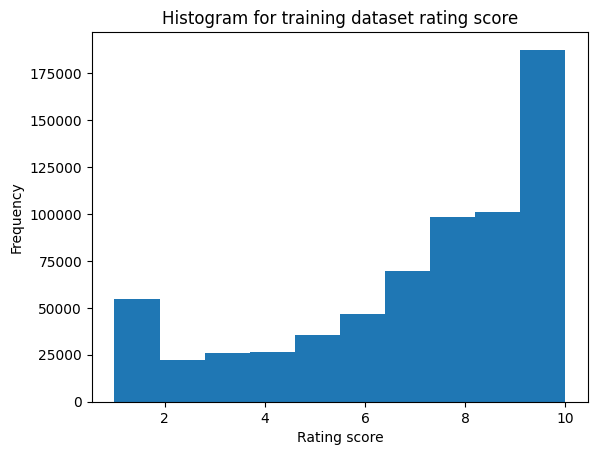

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram
plt.hist(y_train, bins=10)

# Set the title and labels for the axes
plt.title('Histogram for training dataset rating score')
plt.xlabel('Rating score')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [ ]:
# Result for baseline
list_baseline = [np.mean(y_train)]
y_pred_baseline = np.array(list_baseline*len(y_pred))

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_baseline.round()))
print("F1-score:", f1_score(y_test, y_pred_baseline.round(), average='macro'))
print("RMSE:", mean_squared_error(y_test, y_pred_baselaine, squared=False))
print("MSE:", mean_squared_error(y_test, y_pred_baseline, squared=True))

Accuracy: 0.1051070800798766
F1-score: 0.019022062562892912
RMSE: 2.8815080605960026
MSE: 8.303088703279737


In [ ]:
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, eval_dataset = train_test_split(reviews, test_size=0.2, random_state=42)

train_dataset = train_dataset[["review","rating"]]
eval_dataset = eval_dataset[["review","rating"]]

train_dataset = train_dataset.rename(columns={'review': 'text', 'rating': 'score'})
eval_dataset = eval_dataset.rename(columns={'review': 'text', 'rating': 'score'})

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_dataset)
eval_dataset = Dataset.from_pandas(eval_dataset)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "microsoft/MiniLM-L12-H384-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ds = {"train": train_dataset, "test": eval_dataset}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])

Map:   0%|          | 0/669031 [00:00<?, ? examples/s]

Map:   0%|          | 0/167258 [00:00<?, ? examples/s]

In [ ]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    logits_list = list(map(int, list(np.rint(logits))))
    labels_list = list(map(int, list(np.rint(labels))))
    errors = ((np.array(logits_list) - np.array(labels_list)).flatten()**2).tolist()
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in errors if e == 0]) / len(errors)
    
    return {"mse": mse, "rmse": rmse, "mae": mae, "accuracy": accuracy}

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="SI630",  # output directory
    learning_rate=1e-5,
    num_train_epochs=2,  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,  # batch size for evaluation
    weight_decay=0.01,  # strength of weight decay
    do_eval=True,
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=4000,
)

In [ ]:
import torch

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mse,Rmse,Mae,Accuracy
4000,3.058900,2.741943,2.741943,1.655881,1.226576,0.234817
8000,2.708600,2.528818,2.528818,1.590226,1.123806,0.350530
12000,2.366400,2.360304,2.360304,1.536328,1.072321,0.374135
16000,2.308200,2.240104,2.240104,1.496698,1.043192,0.365400
20000,2.177100,2.155097,2.155097,1.468025,1.039747,0.368568
24000,2.201300,2.073467,2.073467,1.439954,1.004510,0.378499
28000,2.198100,2.041213,2.041213,1.428710,0.985892,0.392693
32000,2.160700,1.993727,1.993727,1.411994,0.982433,0.389159
36000,2.057900,1.970012,1.970012,1.403571,0.966455,0.401254
40000,2.125400,1.981597,1.981597,1.407692,0.981656,0.381046


TrainOutput(global_step=83630, training_loss=2.3002793192222017, metrics={'train_runtime': 13620.9051, 'train_samples_per_second': 98.236, 'train_steps_per_second': 6.14, 'total_flos': 4.407010722321715e+16, 'train_loss': 2.3002793192222017, 'epoch': 2.0})

# Rating score prediction by keywords sentence part

In [ ]:
keyword_reviews = reviews[(reviews['review'].str.len() >= 5000) & (reviews['review'].str.len() <= 5400)]

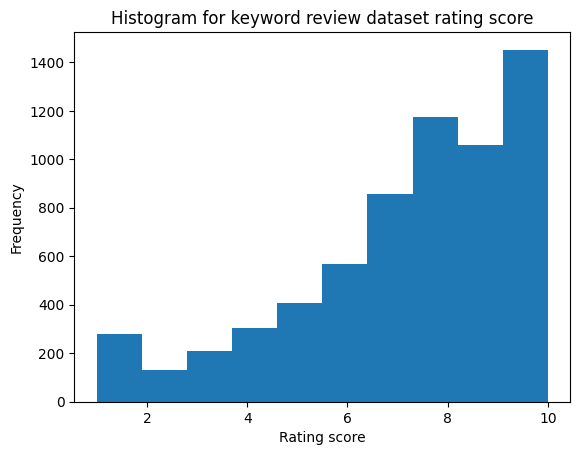

In [ ]:
# Create a histogram
plt.hist(keyword_reviews['rating'], bins=10)

# Set the title and labels for the axes
plt.title('Histogram for keyword review dataset rating score')
plt.xlabel('Rating score')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [ ]:
len(keyword_reviews)

6437

In [ ]:
from keybert import KeyBERT

# Load the model
kw_model = KeyBERT(model='valurank/MiniLM-L6-Keyword-Extraction')

# Define a function to extract keywords
def extract_keywords(row):
    # Get the review text
    review_text = row['review']
    
    # Use KeyBERT to extract keywords
    keywords = kw_model.extract_keywords(review_text, keyphrase_ngram_range=(10, 40), top_n = 1)
    
    # Return the top 1 keywords as a list
    return keywords[0][0]

# Apply the function to the dataframe to create a new column with the extracted keywords
tqdm.pandas()
keyword_reviews['KeyBERT_keywords'] = keyword_reviews.progress_apply(extract_keywords, axis=1)


100%|██████████| 6437/6437 [9:14:41<00:00,  5.17s/it]
<ipython-input-187-b39075873b7c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keyword_reviews['KeyBERT_keywords'] = keyword_reviews.progress_apply(extract_keywords, axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, eval_dataset = train_test_split(keyword_reviews, test_size=0.2)

train_dataset = train_dataset[["KeyBERT_keywords","rating"]]
eval_dataset = eval_dataset[["KeyBERT_keywords","rating"]]

train_dataset = train_dataset.rename(columns={'KeyBERT_keywords': 'text', 'rating': 'score'})
eval_dataset = eval_dataset.rename(columns={'KeyBERT_keywords': 'text', 'rating': 'score'})

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_dataset)
eval_dataset = Dataset.from_pandas(eval_dataset)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "microsoft/MiniLM-L12-H384-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ds = {"train": train_dataset, "test": eval_dataset}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])

In [ ]:
ds = {"train": train_dataset, "test": eval_dataset}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])

Map:   0%|          | 0/5149 [00:00<?, ? examples/s]

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

In [ ]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    logits_list = list(map(int, list(np.rint(logits))))
    labels_list = list(map(int, list(np.rint(labels))))
    errors = ((np.array(logits_list) - np.array(labels_list)).flatten()**2).tolist()
    
    return {"mse": mse, "rmse": rmse, "mae": mae}

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="SI630",  # output directory
    learning_rate=1e-5,
    num_train_epochs=15,  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,  # batch size for evaluation
    weight_decay=0.01,  # strength of weight decay
    do_eval=True,
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=300,
)

In [ ]:
import torch

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Step,Training Loss,Validation Loss,Mse,Rmse,Mae
300,No log,18.924122,18.924122,4.350186,3.934732
600,26.296500,7.719726,7.719726,2.778440,2.417341
900,26.296500,6.182824,6.182824,2.486529,2.019892
1200,7.128000,6.149402,6.149402,2.479799,1.981252
1500,5.944200,5.604808,5.604808,2.367448,1.913583
1800,5.944200,5.541747,5.541746,2.354091,1.869778
2100,5.308300,5.521077,5.521077,2.349697,1.831738
2400,5.308300,5.922416,5.922416,2.433601,1.885574
2700,4.697300,6.260534,6.260534,2.502106,1.992973
3000,4.228400,5.898092,5.898092,2.428599,1.885690


TrainOutput(global_step=4830, training_loss=6.896142578125, metrics={'train_runtime': 1334.8679, 'train_samples_per_second': 57.86, 'train_steps_per_second': 3.618, 'total_flos': 2543794481410560.0, 'train_loss': 6.896142578125, 'epoch': 15.0})

#Other Things I Tried: rating score prediction by title 

In [11]:
reviews['title'] = reviews['title'].str.rstrip('\n')

In [14]:
from transformers import Trainer, TrainingArguments, RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch

In [15]:
from sklearn.model_selection import train_test_split
train_dataset, eval_dataset = train_test_split(reviews, test_size=0.2, random_state=42)

train_dataset = train_dataset[["title","rating"]]
eval_dataset = eval_dataset[["title","rating"]]

train_dataset = train_dataset.rename(columns={'title': 'text', 'rating': 'score'})
eval_dataset = eval_dataset.rename(columns={'title': 'text', 'rating': 'score'})

In [16]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_dataset)
eval_dataset = Dataset.from_pandas(eval_dataset)

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from torch.utils.data import DataLoader

BASE_MODEL = "microsoft/MiniLM-L12-H384-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
ds = {"train": train_dataset, "test": eval_dataset}

def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=["text", "score"])

Map:   0%|          | 0/669031 [00:00<?, ? examples/s]

Map:   0%|          | 0/167258 [00:00<?, ? examples/s]

In [19]:
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    logits_list = list(map(int, list(np.rint(logits))))
    labels_list = list(map(int, list(np.rint(labels))))
    errors = ((np.array(logits_list) - np.array(labels_list)).flatten()**2).tolist()
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in errors if e == 0]) / len(errors)
    
    return {"mse": mse, "rmse": rmse, "mae": mae, "accuracy": accuracy}

In [23]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="SI630",  # output directory
    learning_rate=1e-5,
    num_train_epochs=2,  # total number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,  # batch size for evaluation
    weight_decay=0.01,  # strength of weight decay
    do_eval=True,
    report_to="none",
    evaluation_strategy="steps",
    eval_steps=13000,
)

In [24]:
import torch

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Mse,Rmse,Mae,Accuracy
13000,3.940900,3.660914,3.660914,1.913352,1.360304,0.304619
